In [1]:
# #download dataset
# !wget -N http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
# !tar -xzf VOCtrainval_06-Nov-2007.tar

In [2]:
import os
import random
import numpy as np
import torch
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import trange, tqdm
import wandb

from networks import network1, network2, network3, network4, network5, network6
from utils import VOC2007Dataset, ssim, show_images

In [3]:
wandb.login()
config_kwargs = dict(batch_size=2000, epochs=50, lr=0.001, no_cuda=False, window_size=12,
                                 seed=42, log_interval=10)
def create_new_run(project_name, run_name, configs):
    wandb.init(project=project_name, name=run_name)
    wandb.config.update({k: v for k, v in configs.items()})      # Initialize config
project_name = "Y-Data-DL-Week4-Super-Resolution-GPU"
create_new_run(project_name, 'Model 1', config_kwargs)

In [4]:
config = wandb.config
use_cuda = not config.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {'num_workers': 2}

random.seed(config.seed)       # python random seed
torch.manual_seed(config.seed) # pytorch random seed
np.random.seed(config.seed) # numpy random seed

<IPython.core.display.Javascript object>

In [5]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = VOC2007Dataset(image_set='trainval', transform=transform, sample_slice=[0,21]) # training dataset
trainloader = DataLoader(trainset, batch_size=config.batch_size, shuffle=False, **kwargs)
testset = VOC2007Dataset(image_set='trainval', transform=transform, sample_slice=[-3, -1]) # validation dataset
testloader = DataLoader(testset, batch_size=config.batch_size, shuffle=False, **kwargs)

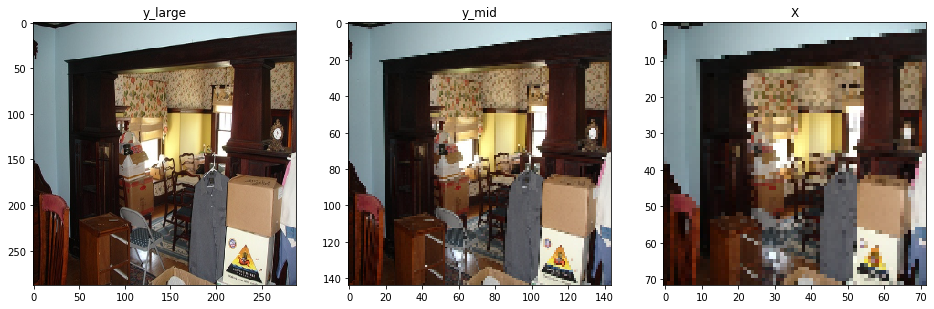

In [6]:
show_images(trainset[0])

In [8]:
def train_model_y_mid(config, net, train_data, optimizer, epoch):
    net.train()
    train_loss = 0
    for batch in train_data:
        X = batch['X'].to(device)
        y_mid = batch['y_mid'].to(device)
        optimizer.zero_grad()
        output = net(X)
        loss = 1-ssim(output, y_mid, window_size=config.window_size)
        loss.backward()
        optimizer.step()
        if use_cuda: torch.cuda.empty_cache()
        train_loss += loss.item()
    wandb.log({'Train Loss': train_loss/len(train_data)}, step=epoch)

def test_model_y_mid(config, net, test_data, epoch):
    net.eval()
    test_loss = 0
    mse_loss = 0
    example_images = []
    avg_psnr = 0
    n = len(test_data)
    with torch.no_grad():
        for batch in test_data:
            X = batch['X'].to(device)
            y_mid = batch['y_mid'].to(device)
            output = net(X)
            loss = 1-ssim(output, y_mid, window_size=config.window_size)
            test_loss += loss
            mse = F.mse_loss(output, y_mid).item()
            mse_loss += mse
            avg_psnr += 10 * np.log10(1/mse)
            if use_cuda: torch.cuda.empty_cache()
            example_images.append(wandb.Image(transforms.ToPILImage(mode='RGB')(output[0].cpu()), 
                                              caption="Output Reconstruction"))
            example_images.append(wandb.Image(transforms.ToPILImage(mode='RGB')(y_mid[0].cpu()), 
                                              caption="Target"))
        wandb.log({'Test Loss': test_loss/n, 'Avg PSN Ratio - Test': avg_psnr/n,
                   'MSE Loss - Test': mse_loss/n, "Examples": example_images}, step=epoch)

In [9]:
def run_training(network):
    model = network().to(device)
    wandb.watch(model, log="all")
    optimizer = optim.Adam(model.parameters(), lr=config.lr)
    for epoch in trange(1, config.epochs + 1):
        train_model_y_mid(config, model, trainloader, optimizer, epoch)
        test_model_y_mid(config, model, testloader, epoch)
    return model

In [10]:
model1 = run_training(network1)

  0%|          | 0/50 [00:00<?, ?it/s]


RuntimeError: DataLoader worker (pid(s) 99397) exited unexpectedly

In [ ]:
dataiter = iter(trainloader)
test = next(dataiter)
y_mid = model1(test['X'])
img_dct = dict(y_mid=y_mid[0], X=test['X'][0])
show_images(img_dct)

In [ ]:
def train_model_y_mid_large(config, net, train_data, optimizer, epoch):
    net.train()
    train_loss = 0
    for batch in train_data:
        X = batch['X'].to(device)
        y_mid = batch['y_mid'].to(device)
        y_large = batch['y_large'].to(device)
        optimizer.zero_grad()
        mid_output, large_output = net(X)
        loss = ((1-ssim(mid_output, y_mid, window_size=config.window_size)) + 
                (1-ssim(large_output, y_large,window_size=config.window_size)))
        loss.backward()
        optimizer.step()
        if use_cuda: torch.cuda.empty_cache()
        train_loss += loss.item()
    wandb.log({'Train Loss': train_loss/len(train_data)}, step=epoch)

def test_model_y_mid_large(config, net, test_data, epoch):
    net.eval()
    test_loss = 0
    mse_loss = 0
    example_images = []
    avg_psnr = 0
    n = len(test_data)
    loss_fn = ssim
    with torch.no_grad():
        for batch in test_data:
            X = batch['X'].to(device)
            y_mid = batch['y_mid'].to(device)
            y_large = batch['y_large'].to(device)
            mid_output, large_output = net(X)
            loss = ((1-ssim(mid_output, y_mid, window_size=config.window_size)) + 
                    (1-ssim(large_output, y_large, window_size=config.window_size)))
            test_loss += loss
            mse = F.mse_loss(mid_output, y_mid).item() + F.mse_loss(large_output, y_large).item()
            mse_loss += mse
            avg_psnr += 10 * np.log10(1/mse)
            if use_cuda: torch.cuda.empty_cache()
            example_images.append(wandb.Image(transforms.ToPILImage(mode='RGB')(mid_output[0].cpu()), 
                                                caption="Mid Output Reconstruction"))
            example_images.append(wandb.Image(transforms.ToPILImage(mode='RGB')(large_output[0].cpu()), 
                                                caption="Large Output Reconstruction"))
            example_images.append(wandb.Image(transforms.ToPILImage(mode='RGB')(y_mid[0].cpu()), 
                                                caption="Target"))
        wandb.log({'Test Loss': test_loss/n, 'Avg PSN Ratio - Test': avg_psnr/n,
                    'MSE Loss - Test': mse_loss/n, "Examples": example_images}, step=epoch)

In [ ]:
def run_training2(network):
    model = network().to(device)
    wandb.watch(model, log="all")
    optimizer = optim.Adam(model.parameters(), lr=config.lr)
    for epoch in trange(1, config.epochs + 1):
        train_model_y_mid_large(config, model, trainloader, optimizer, epoch)
        test_model_y_mid_large(config, model, testloader, epoch)
    return model

In [ ]:
create_new_run(project_name, 'Model 2', config_kwargs)
model2 = run_training2(network2)

In [ ]:
def show_test_images(model, test):
    y_mid, y_large = model(test['X'])
    img_dct = dict(y_large_pred=y_large[0], y_mid_pred=y_mid[0], X=test['X'][0], )
    show_images(img_dct)

In [ ]:
show_test_images(model2, test=test)

In [ ]:
create_new_run(project_name, 'Model 3', config_kwargs)
model3 = run_training2(network3)

In [ ]:
show_test_images(model3, test=test)

In [ ]:
create_new_run(project_name, 'Model 4', config_kwargs)
model4 = run_training2(network4)

In [ ]:
show_test_images(model4, test=test)

In [ ]:
create_new_run(project_name, 'Model 5', config_kwargs)
model5 = run_training2(network5)

In [ ]:
show_test_images(model5, test=test)

In [ ]:
create_new_run(project_name, 'Model 6', config_kwargs)
model6 = run_training2(network6)

In [ ]:
show_test_images(model6, test=test)